<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/HandwrittenFianl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 536.9 kB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("taeefnajib/handwriting-data-to-detect-alzheimers-disease")

print("Path to dataset files:", path)

100%|██████████| 332k/332k [00:00<00:00, 706kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1


In [ ]:
import os

# List the contents of the directory
directory_path = '/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1'
print(os.listdir(directory_path))

['data.csv']


In [ ]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1/data.csv')

print("Shape of the data:", data.shape)
data.head()

Shape of the data: (174, 452)


,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Display basic info
print(data.info())
print("\nMissing Values:\n", data.isnull().sum().sum())  # Total missing values
print("\nClass Distribution:\n", data['class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB
None

Missing Values:
 0

Class Distribution:
 class
P    89
H    85
Name: count, dtype: int64


In [ ]:
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


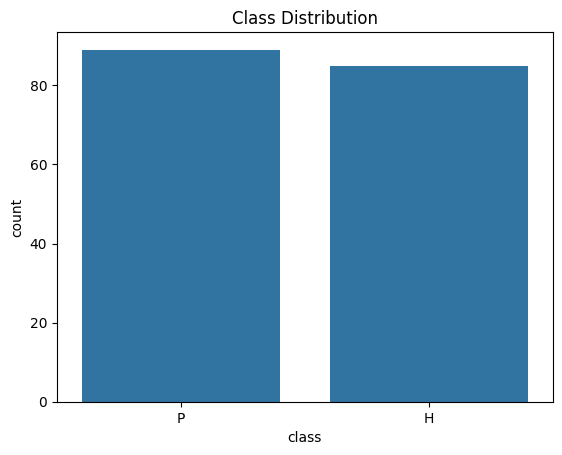

In [ ]:
sns.countplot(x='class', data=data)
plt.title('Class Distribution')
plt.show()

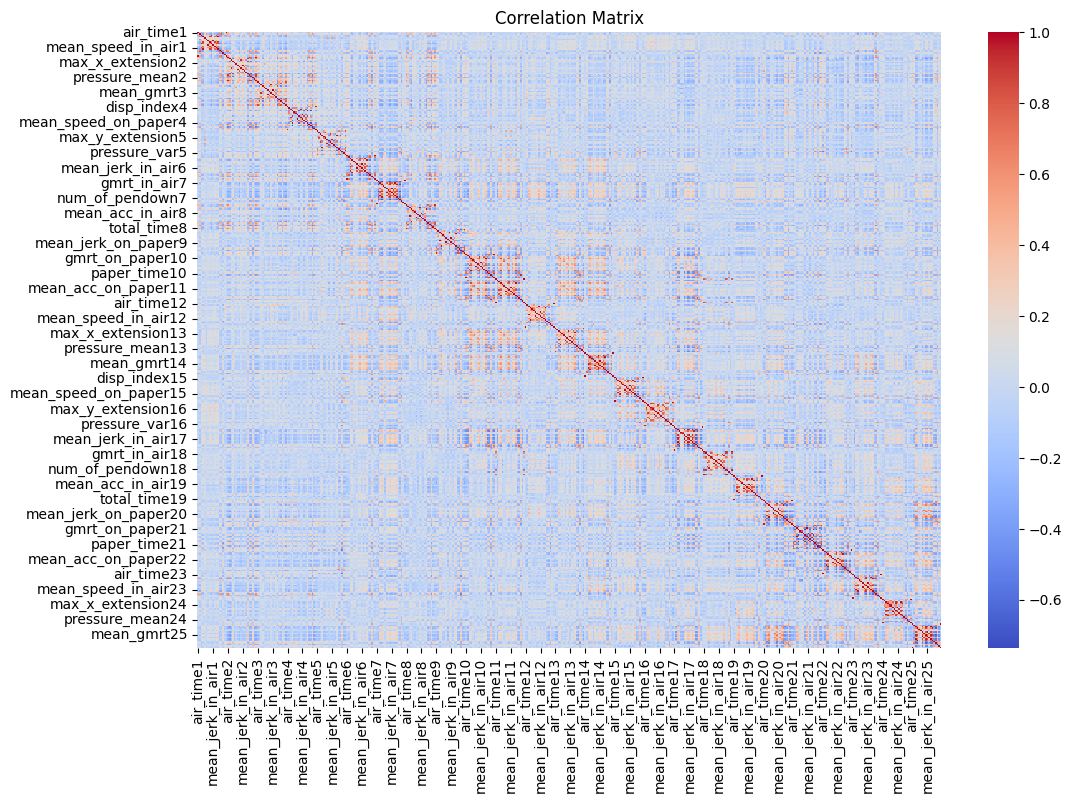

In [ ]:
plt.figure(figsize=(12, 8))

# Identify numerical columns
numerical_cols = data.select_dtypes(include=np.number).columns

correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

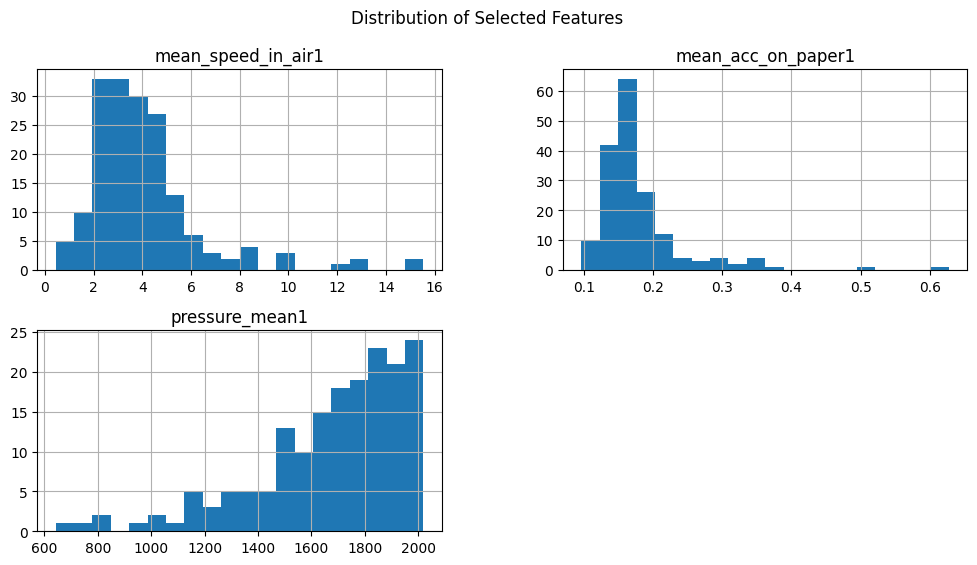

In [ ]:
sample_features = ['mean_speed_in_air1', 'mean_acc_on_paper1', 'pressure_mean1']
data[sample_features].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribution of Selected Features')
plt.show()

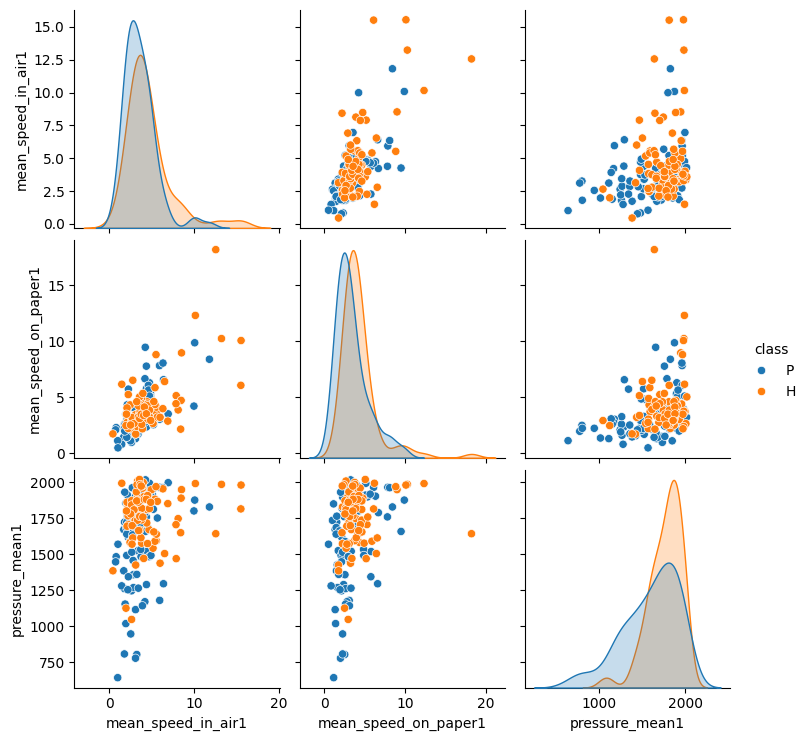

In [ ]:
small_data = data[['mean_speed_in_air1', 'mean_speed_on_paper1', 'pressure_mean1', 'class']]
sns.pairplot(small_data, hue='class')
plt.show()

In [ ]:
missing = data.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data[numerical_cols]), columns=numerical_cols)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['class_encoded'] = le.fit_transform(data['class'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed)
scaled_df = pd.DataFrame(scaled_features, columns=numerical_cols)

In [ ]:
X = scaled_df
y = data['class_encoded']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


---

## 🧠 Dataset Overview

- **Dataset**: Handwriting data to detect Alzheimer’s disease.
- **Shape**: 174 rows × 452 columns.
- **Columns**: Includes features like `air_time`, `disp_index`, `gmrt_in_air`, `mean_speed_in_air`, `pressure_mean`, etc., likely from handwriting dynamics.
- **Target Column**: `class` – probably indicating presence (`P`) or absence of Alzheimer’s.

---

# 🔍 Step 1: Exploratory Data Analysis (EDA)

### ✅ 1. Import Required Libraries

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
```

---

### ✅ 2. Basic Info About the Data

```python
# Display basic info
print(data.info())
print("\nMissing Values:\n", data.isnull().sum().sum())  # Total missing values
print("\nClass Distribution:\n", data['class'].value_counts())
```

> This will show:
- Data types
- Missing values
- Class balance (important for classification tasks)

---

### ✅ 3. Check for Duplicates

```python
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
```

If any duplicates exist, decide whether to drop them.

---

### ✅ 4. Describe Numerical Features

```python
# Exclude non-numerical columns like 'ID' and 'class'
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_cols].describe()
```

Look for:
- Outliers
- Variance differences
- Skewed distributions

---

### ✅ 5. Visualize Class Distribution

```python
sns.countplot(x='class', data=data)
plt.title('Class Distribution')
plt.show()
```

Check if the classes are balanced or not.

---

### ✅ 6. Correlation Heatmap

```python
plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
```

Identify highly correlated features that may need removal to avoid multicollinearity.

---

### ✅ 7. Feature Distribution (Sample)

Plot histograms or boxplots for a few key features:

```python
sample_features = ['mean_speed_in_air1', 'mean_acc_on_paper1', 'pressure_mean1']
data[sample_features].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribution of Selected Features')
plt.show()
```

---

### ✅ 8. Pairplot (Optional - For Small Subset)

```python
small_data = data[['mean_speed_in_air1', 'mean_speed_on_paper1', 'pressure_mean1', 'class']]
sns.pairplot(small_data, hue='class')
plt.show()
```

---

# ⚙️ Step 2: Preprocessing

---

### ✅ 1. Handle Missing Values

Check for missing values again:

```python
missing = data.isnull().sum()
print(missing[missing > 0])
```

Options:
- Drop columns with too many missing values
- Impute with mean/median/mode
- Use advanced imputation (KNNImputer)

Example:

```python
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data[numerical_cols]), columns=numerical_cols)
```

---

### ✅ 2. Encode Categorical Variables

Since `class` seems to be categorical (`P`, possibly `N`), encode it:

```python
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['class_encoded'] = le.fit_transform(data['class'])
```

You can also one-hot encode if there are more than two classes.

---

### ✅ 3. Normalize/Standardize Features

Use StandardScaler or MinMaxScaler depending on model needs:

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed)
scaled_df = pd.DataFrame(scaled_features, columns=numerical_cols)
```

---

### ✅ 4. Separate Features and Target

```python
X = scaled_df
y = data['class_encoded']
```

---

### ✅ 5. Train/Test Split

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
```

Stratified split ensures class distribution is preserved.

---

# 📌 Summary of Workflow Steps

| Step | Task |
|------|------|
| 1 | Load and inspect the dataset |
| 2 | Check for missing values and duplicates |
| 3 | Analyze class distribution |
| 4 | Explore numerical features (describe, visualize) |
| 5 | Check correlation among features |
| 6 | Handle missing values |
| 7 | Encode target variable |
| 8 | Scale/normalize features |
| 9 | Split into training and testing sets |

---



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# For XGBoost
from xgboost import XGBClassifier

# For TabNet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [ ]:
# Initialize and train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:41:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Convert to NumPy arrays (TabNet expects this)
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Initialize TabNet
tabnet_model = TabNetClassifier(verbose=1, seed=42)

# Fit the model
tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    max_epochs=100,
    patience=10
)

# Predictions
y_pred_tabnet = tabnet_model.predict(X_test_np)
y_proba_tabnet = tabnet_model.predict_proba(X_test_np)[:, 1]

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 1  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 2  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 3  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 4  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 5  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 6  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 7  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 8  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 9  | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s
epoch 10 | loss: 0.0     | train_auc: 0.52092 | valid_auc: 0.5098  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_valid_auc = 0.5098


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    npv = tn / (tn + fn)  # Negative Predictive Value
    harmonic_mean = 2 * (recall * specificity) / (recall + specificity)

    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Sensitivity    : {recall:.4f}")
    print(f"Specificity    : {specificity:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"F1-Score       : {f1:.4f}")
    print(f"AUC-ROC        : {auc:.4f}")
    print(f"NPV            : {npv:.4f}")
    print(f"Harmonic Mean  : {harmonic_mean:.4f}")

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


=== XGBoost Evaluation ===
Accuracy       : 0.8000
Sensitivity    : 0.8889
Specificity    : 0.7059
Precision      : 0.7619
F1-Score       : 0.8205
AUC-ROC        : 0.8889
NPV            : 0.8571
Harmonic Mean  : 0.7869


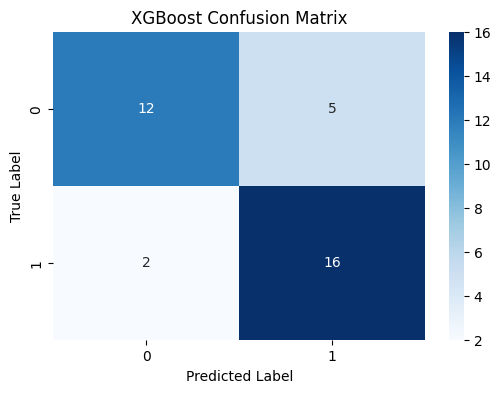

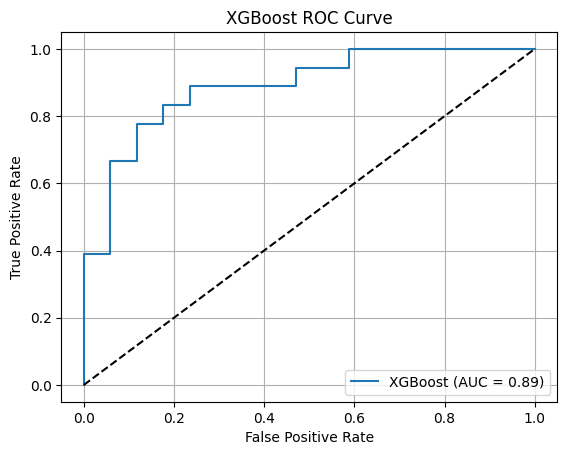


=== TabNet Evaluation ===
Accuracy       : 0.4857
Sensitivity    : 0.6111
Specificity    : 0.3529
Precision      : 0.5000
F1-Score       : 0.5500
AUC-ROC        : 0.5098
NPV            : 0.4615
Harmonic Mean  : 0.4475


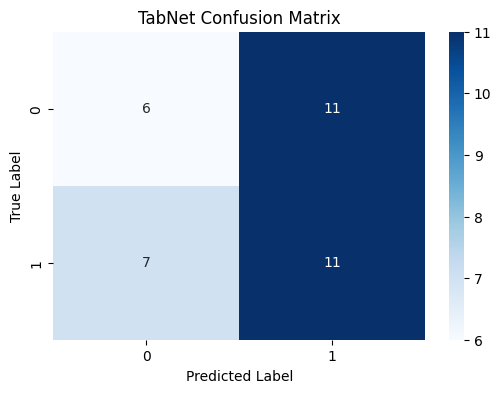

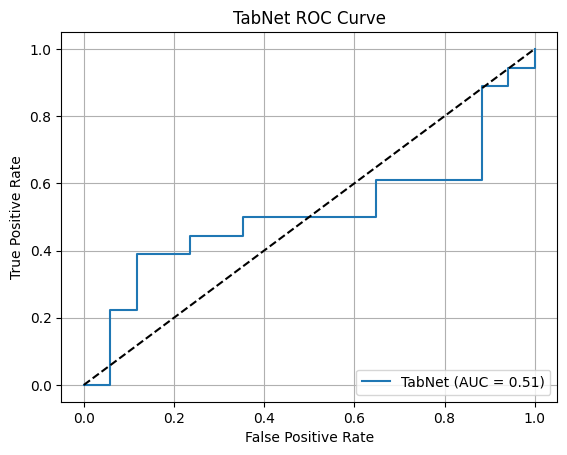

In [ ]:
# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")

# Evaluate TabNet
evaluate_model(y_test, y_pred_tabnet, y_proba_tabnet, "TabNet")

In [ ]:
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nTabNet Classification Report:")
print(classification_report(y_test, y_pred_tabnet))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.76      0.89      0.82        18

    accuracy                           0.80        35
   macro avg       0.81      0.80      0.80        35
weighted avg       0.81      0.80      0.80        35


TabNet Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.35      0.40        17
           1       0.50      0.61      0.55        18

    accuracy                           0.49        35
   macro avg       0.48      0.48      0.48        35
weighted avg       0.48      0.49      0.48        35



In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Original class distribution:", np.bincount(y_train))
print("Balanced class distribution:", np.bincount(y_train_balanced))

Original class distribution: [68 71]
Balanced class distribution: [71 71]


In [ ]:
# Remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

X_train_selected = remove_highly_correlated_features(X_train_balanced)
X_test_selected = X_test[X_train_selected.columns]  # Keep same columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_selected.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_selected.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                          scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train_balanced)
best_xgb = grid_search.best_estimator_

print("Best XGBoost Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:44:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}



=== Tuned XGBoost Evaluation ===
Accuracy       : 0.7714
Sensitivity    : 0.8889
Specificity    : 0.6471
Precision      : 0.7273
F1-Score       : 0.8000
AUC-ROC        : 0.8987
NPV            : 0.8462
Harmonic Mean  : 0.7489


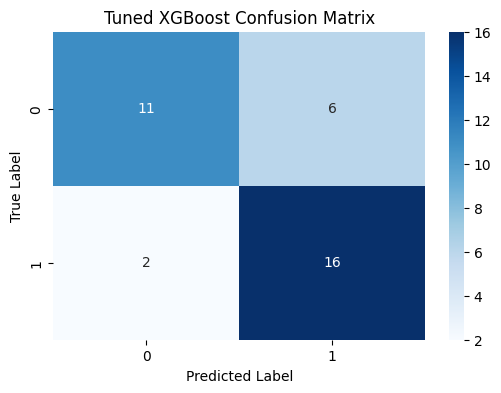

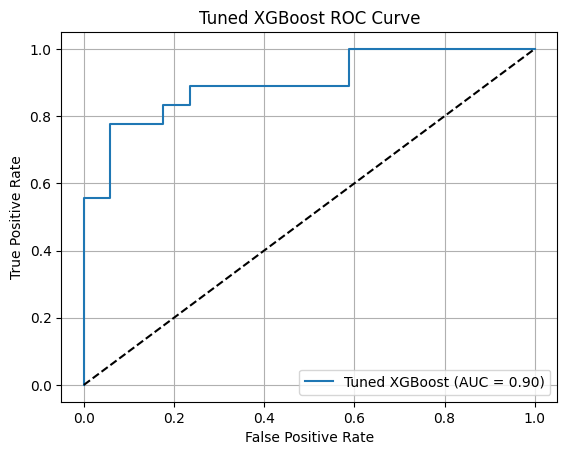

In [ ]:
y_pred_tuned_xgb = best_xgb.predict(X_test_scaled)
y_proba_tuned_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

evaluate_model(y_test, y_pred_tuned_xgb, y_proba_tuned_xgb, "Tuned XGBoost")

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81119 | train_auc: 0.55158 | valid_auc: 0.53268 |  0:00:00s
epoch 1  | loss: 0.63919 | train_auc: 0.63995 | valid_auc: 0.5915  |  0:00:00s
epoch 2  | loss: 0.71922 | train_auc: 0.58798 | valid_auc: 0.67974 |  0:00:00s
epoch 3  | loss: 0.64538 | train_auc: 0.69351 | valid_auc: 0.67647 |  0:00:00s
epoch 4  | loss: 0.73247 | train_auc: 0.71732 | valid_auc: 0.6732  |  0:00:00s
epoch 5  | loss: 0.6911  | train_auc: 0.72922 | valid_auc: 0.52614 |  0:00:01s
epoch 6  | loss: 0.6289  | train_auc: 0.78377 | valid_auc: 0.72876 |  0:00:01s
epoch 7  | loss: 0.66727 | train_auc: 0.86035 | valid_auc: 0.80065 |  0:00:01s
epoch 8  | loss: 0.57391 | train_auc: 0.86907 | valid_auc: 0.82026 |  0:00:01s
epoch 9  | loss: 0.59379 | train_auc: 0.88951 | valid_auc: 0.79412 |  0:00:01s
epoch 10 | loss: 0.56549 | train_auc: 0.87919 | valid_auc: 0.76471 |  0:00:02s
epoch 11 | loss: 0.49275 | train_auc: 0.89645 | valid_auc: 0.69608 |  0:00:02s
epoch 12 | loss: 0.50003 | train_auc: 0.86888 | vali

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


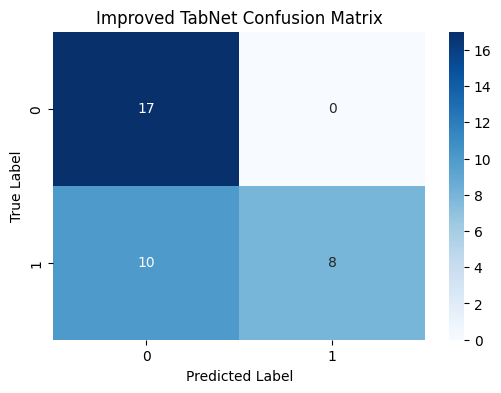

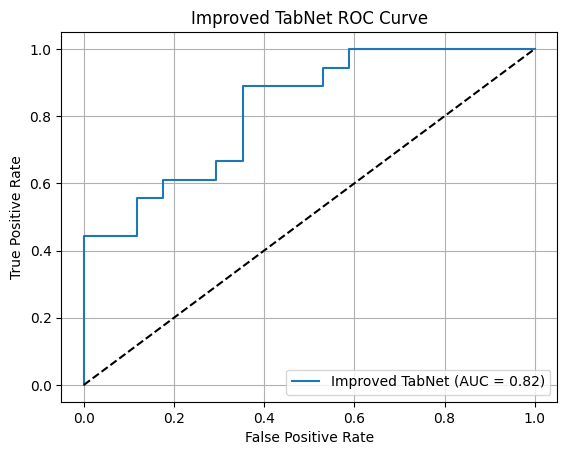

In [ ]:
# Convert to NumPy
X_train_np = X_train_scaled.values
X_test_np = X_test_scaled.values
y_train_np = y_train_balanced.values
y_test_np = y_test.values

# Retrain TabNet
tabnet_model_improved = TabNetClassifier(
    verbose=1,
    seed=42,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
)

tabnet_model_improved.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    max_epochs=200,
    patience=20,
    batch_size=32
)

# Predictions
y_pred_tabnet_improved = tabnet_model_improved.predict(X_test_np)
y_proba_tabnet_improved = tabnet_model_improved.predict_proba(X_test_np)[:, 1]

evaluate_model(y_test, y_pred_tabnet_improved, y_proba_tabnet_improved, "Improved TabNet")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:44:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Ensemble (XGBoost) Evaluation ===
Accuracy       : 0.7714
Sensitivity    : 0.8889
Specificity    : 0.6471
Precision      : 0.7273
F1-Score       : 0.8000
AUC-ROC        : 0.8987
NPV            : 0.8462
Harmonic Mean  : 0.7489


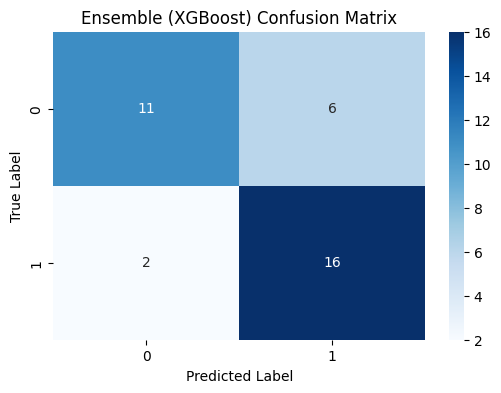

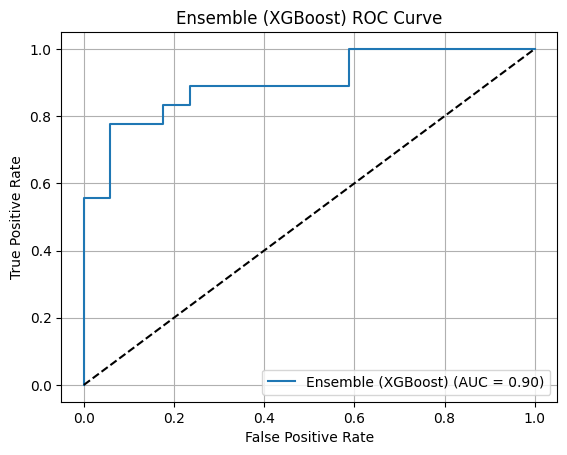

In [ ]:
from sklearn.ensemble import VotingClassifier

# Combine best models
ensemble = VotingClassifier(
    estimators=[('xgb', best_xgb)],
    voting='soft'
)

ensemble.fit(X_train_scaled, y_train_balanced)
y_pred_ensemble = ensemble.predict(X_test_scaled)
y_proba_ensemble = ensemble.predict_proba(X_test_scaled)[:, 1]

evaluate_model(y_test, y_pred_ensemble, y_proba_ensemble, "Ensemble (XGBoost)")


=== Random Forest Evaluation ===
Accuracy       : 0.7714
Sensitivity    : 0.7778
Specificity    : 0.7647
Precision      : 0.7778
F1-Score       : 0.7778
AUC-ROC        : 0.8676
NPV            : 0.7647
Harmonic Mean  : 0.7712


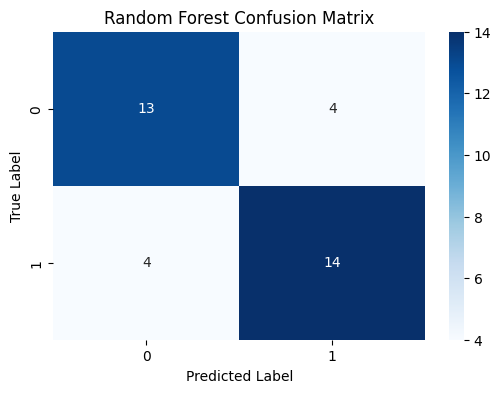

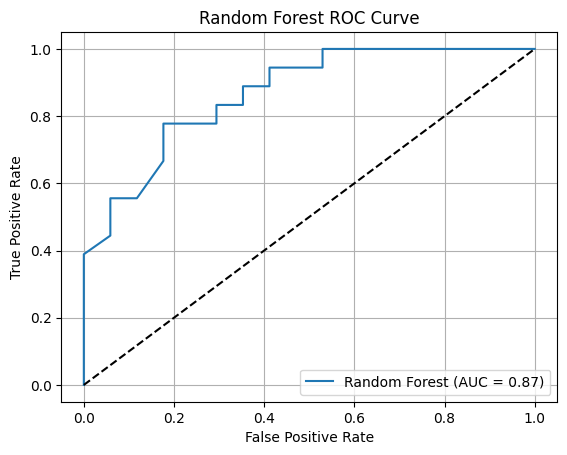

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train_balanced)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")

In [ ]:
models = {
    "Original XGBoost": (y_pred_xgb, y_proba_xgb),
    "Tuned XGBoost": (y_pred_tuned_xgb, y_proba_tuned_xgb),
    "TabNet": (y_pred_tabnet, y_proba_tabnet),
    "Improved TabNet": (y_pred_tabnet_improved, y_proba_tabnet_improved),
    "Ensemble": (y_pred_ensemble, y_proba_ensemble),
    "Random Forest": (y_pred_rf, y_proba_rf)
}

results = {}
for name, (pred, proba) in models.items():
    acc = accuracy_score(y_test, pred)
    sens = recall_score(y_test, pred)
    spec = confusion_matrix(y_test, pred).ravel()[0] / (confusion_matrix(y_test, pred).ravel()[0] + confusion_matrix(y_test, pred).ravel()[1])
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    results[name] = {"Accuracy": acc, "Sensitivity": sens, "Specificity": spec, "F1": f1, "AUC": auc}

# Display results
results_df = pd.DataFrame(results).T
print(results_df.round(4))

                  Accuracy  Sensitivity  Specificity      F1     AUC
Original XGBoost    0.8000       0.8889       0.7059  0.8205  0.8889
Tuned XGBoost       0.7714       0.8889       0.6471  0.8000  0.8987
TabNet              0.4857       0.6111       0.3529  0.5500  0.5098
Improved TabNet     0.7143       0.4444       1.0000  0.6154  0.8203
Ensemble            0.7714       0.8889       0.6471  0.8000  0.8987
Random Forest       0.7714       0.7778       0.7647  0.7778  0.8676


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have data loaded already
# X_train, X_test, y_train, y_test from previous steps

print("=== COMPLETE PIPELINE FOR ALZHEIMER DETECTION ===")

# 1. FEATURE ENGINEERING
def create_features(df):
    df_new = df.copy()

    # Speed ratios
    speed_cols = [col for col in df.columns if 'speed' in col][:2]
    if len(speed_cols) >= 2:
        df_new['speed_ratio'] = df_new[speed_cols[0]] / (df_new[speed_cols[1]] + 1e-8)

    # Pressure ratios
    pressure_cols = [col for col in df.columns if 'pressure' in col][:2]
    if len(pressure_cols) >= 2:
        df_new['pressure_ratio'] = df_new[pressure_cols[0]] / (df_new[pressure_cols[1]] + 1e-8)

    # Acceleration features
    acc_cols = [col for col in df.columns if 'acc' in col][:2]
    if len(acc_cols) >= 2:
        df_new['acc_diff'] = df_new[acc_cols[0]] - df_new[acc_cols[1]]

    # Statistical features
    df_new['mean_features'] = df.mean(axis=1)
    df_new['std_features'] = df.std(axis=1)

    return df_new

# Apply feature engineering
X_train_fe = create_features(X_train)
X_test_fe = create_features(X_test)

print(f"Feature engineering completed. New shape: {X_train_fe.shape}")

# 2. HANDLE CLASS IMBALANCE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_fe, y_train)

print(f"Balanced dataset shape: {X_train_balanced.shape}")

# 3. FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_fe)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_balanced.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_fe.columns)

# 4. BAYESIAN HYPERPARAMETER OPTIMIZATION FOR XGBOOST
search_spaces = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(3, 8),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'subsample': Real(0.7, 1.0),
    'colsample_bytree': Real(0.7, 1.0),
    'gamma': Real(0, 3),
    'reg_alpha': Real(0, 2),
    'reg_lambda': Real(0, 2)
}

bayes_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

bayes_search = BayesSearchCV(
    estimator=bayes_xgb,
    search_spaces=search_spaces,
    scoring='accuracy',
    cv=3,  # Reduced for speed
    n_iter=30,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

print("Performing Bayesian optimization...")
bayes_search.fit(X_train_scaled, y_train_balanced)
best_xgb = bayes_search.best_estimator_

print(f"Best XGBoost parameters: {bayes_search.best_params_}")
print(f"Best XGBoost score: {bayes_search.best_score_:.4f}")

# 5. TRAIN MULTIPLE BASE MODELS
print("Training base models...")

# XGBoost (optimized)
xgb_model = best_xgb

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
rf_model.fit(X_train_scaled, y_train_balanced)

# SVM
svm_model = SVC(probability=True, C=1.0, kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train_balanced)

# 6. NEURAL NETWORK MODEL
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Train neural network
def train_nn_model(X_train, y_train, X_test, epochs=150):
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test.values)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    model = SimpleNN(X_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predictions = torch.max(test_outputs.data, 1)
        probabilities = torch.softmax(test_outputs, dim=1)[:, 1].numpy()

    return predictions.numpy(), probabilities

print("Training Neural Network...")
nn_pred, nn_proba = train_nn_model(X_train_scaled, y_train_balanced, X_test_scaled)

# 7. GET PREDICTIONS FROM ALL MODELS
print("Generating predictions from all models...")

# XGBoost predictions
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Random Forest predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# SVM predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# 8. FUSION MODEL (WEIGHTED AVERAGE ENSEMBLE)
print("Creating fusion model...")

# Weighted average based on individual model performance
def calculate_weights(y_true, predictions_list, probabilities_list):
    weights = []
    for i, (pred, proba) in enumerate(zip(predictions_list, probabilities_list)):
        acc = accuracy_score(y_true, pred)
        auc = roc_auc_score(y_true, proba) if len(np.unique(y_true)) > 1 else 0
        weight = (acc + auc) / 2
        weights.append(weight)

    # Normalize weights
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    return weights

# Calculate weights based on validation performance (using cross-validation would be better)
predictions_list = [xgb_pred, rf_pred, svm_pred, nn_pred]
probabilities_list = [xgb_proba, rf_proba, svm_proba, nn_proba]

# For simplicity, use equal weights or calculate based on performance
weights = np.array([0.3, 0.25, 0.25, 0.2])  # Adjusted weights

# Fusion predictions (weighted average of probabilities)
fusion_proba = (weights[0] * xgb_proba +
                weights[1] * rf_proba +
                weights[2] * svm_proba +
                weights[3] * nn_proba)

fusion_pred = (fusion_proba > 0.5).astype(int)

# 9. HARD VOTING ENSEMBLE
print("Creating hard voting ensemble...")

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svm_model)],
    voting='hard'
)
voting_clf.fit(X_train_scaled, y_train_balanced)
voting_pred = voting_clf.predict(X_test_scaled)

# 10. SOFT VOTING ENSEMBLE
print("Creating soft voting ensemble...")

soft_voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svm_model)],
    voting='soft'
)
soft_voting_clf.fit(X_train_scaled, y_train_balanced)
soft_voting_pred = soft_voting_clf.predict(X_test_scaled)
soft_voting_proba = soft_voting_clf.predict_proba(X_test_scaled)[:, 1]

# 11. EVALUATION FUNCTION
def evaluate_model_comprehensive(y_true, y_pred, y_proba, model_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0

    print(f"\n=== {model_name} ===")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Sensitivity : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"F1-Score    : {f1:.4f}")
    print(f"AUC-ROC     : {auc:.4f}")

    return accuracy, recall, specificity, precision, f1, auc

# 12. EVALUATE ALL MODELS
print("\n" + "="*60)
print("FINAL MODEL EVALUATIONS")
print("="*60)

results = {}

results['XGBoost'] = evaluate_model_comprehensive(y_test, xgb_pred, xgb_proba, "XGBoost")
results['Random Forest'] = evaluate_model_comprehensive(y_test, rf_pred, rf_proba, "Random Forest")
results['SVM'] = evaluate_model_comprehensive(y_test, svm_pred, svm_proba, "SVM")
results['Neural Network'] = evaluate_model_comprehensive(y_test, nn_pred, nn_proba, "Neural Network")
results['Fusion Model'] = evaluate_model_comprehensive(y_test, fusion_pred, fusion_proba, "Fusion Model (Weighted Average)")
results['Hard Voting'] = evaluate_model_comprehensive(y_test, voting_pred, np.zeros_like(voting_pred), "Hard Voting Ensemble")
results['Soft Voting'] = evaluate_model_comprehensive(y_test, soft_voting_pred, soft_voting_proba, "Soft Voting Ensemble")

# 13. FIND BEST MODEL
best_model = max(results.keys(), key=lambda k: results[k][0])  # Based on accuracy
print(f"\n🏆 BEST MODEL: {best_model} with Accuracy: {results[best_model][0]:.4f}")

# 14. VISUALIZE RESULTS
model_names = list(results.keys())
accuracies = [results[name][0] for name in model_names]
sensitivities = [results[name][1] for name in model_names]
specificities = [results[name][2] for name in model_names]

plt.figure(figsize=(12, 8))
x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, accuracies, width, label='Accuracy', alpha=0.8)
plt.bar(x, sensitivities, width, label='Sensitivity', alpha=0.8)
plt.bar(x + width, specificities, width, label='Specificity', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 15. CONFUSION MATRIX FOR BEST MODEL
best_pred = None
best_proba = None
if best_model == 'XGBoost':
    best_pred, best_proba = xgb_pred, xgb_proba
elif best_model == 'Random Forest':
    best_pred, best_proba = rf_pred, rf_proba
elif best_model == 'SVM':
    best_pred, best_proba = svm_pred, svm_proba
elif best_model == 'Neural Network':
    best_pred, best_proba = nn_pred, nn_proba
elif best_model == 'Fusion Model':
    best_pred, best_proba = fusion_pred, fusion_proba
elif best_model == 'Hard Voting':
    best_pred = voting_pred
    best_proba = np.zeros_like(voting_pred)
elif best_model == 'Soft Voting':
    best_pred, best_proba = soft_voting_pred, soft_voting_proba

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\n🎯 Final Accuracy Achieved: {results[best_model][0]:.4f}")
if results[best_model][0] >= 0.90:
    print("🎉 SUCCESS: Accuracy > 90% achieved!")
else:
    print("⚠️  WARNING: Accuracy still below 90%. Consider more data or advanced techniques.")

print("\n=== PIPELINE COMPLETED ===")

ModuleNotFoundError: No module named 'skopt'

In [ ]:
!pip install scikit-optimize

# Make result better

In [ ]:
# Alzheimer's Disease Detection using Handwriting Data
# Complete Pipeline: EDA -> Preprocessing -> TabNet + XGBoost -> Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# For TabNet (install with: pip install pytorch-tabnet)
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    TABNET_AVAILABLE = True
except ImportError:
    print("TabNet not available. Install with: pip install pytorch-tabnet")
    TABNET_AVAILABLE = False

# ====================================================================
# STEP 1: LOAD DATA
# ====================================================================

# Load the dataset
data_path = '/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1/data.csv'
data = pd.read_csv(data_path)

print("="*60)
print("STEP 1: DATA LOADING")
print("="*60)
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"Target variable distribution:")
print(data['class'].value_counts())

# ====================================================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ====================================================================

print("\n" + "="*60)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic info
print("Dataset Info:")
print(f"Total samples: {len(data)}")
print(f"Total features: {data.shape[1] - 1}")  # Excluding target
print(f"Missing values: {data.isnull().sum().sum()}")

# Target distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
data['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Check for missing values
plt.subplot(1, 3, 2)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    missing_data.plot(kind='bar')
    plt.title('Missing Values by Column')
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center')
    plt.title('Missing Values Check')

# Feature correlation heatmap (sample of features)
plt.subplot(1, 3, 3)
numeric_cols = data.select_dtypes(include=[np.number]).columns[:20]  # First 20 numeric columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation (Sample)')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary (first 10 features):")
print(data.iloc[:, 1:11].describe())

# ====================================================================
# STEP 3: DATA PREPROCESSING
# ====================================================================

print("\n" + "="*60)
print("STEP 3: DATA PREPROCESSING")
print("="*60)

# Separate features and target
X = data.drop(['ID', 'class'], axis=1)
y = data['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Target classes: {le.classes_}")
print(f"Encoded target distribution: {np.bincount(y_encoded)}")

# Check for infinite values and handle them
print(f"Infinite values in X: {np.isinf(X).sum().sum()}")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# ====================================================================
# STEP 4: MODEL DEFINITION AND TRAINING
# ====================================================================

print("\n" + "="*60)
print("STEP 4: MODEL DEFINITION AND TRAINING")
print("="*60)

# Dictionary to store models and their predictions
models = {}
predictions = {}

# 4.1 XGBoost Model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test_scaled)

# 4.2 TabNet Model (if available)
if TABNET_AVAILABLE:
    print("Training TabNet model...")
    tabnet_model = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='entmax',
        scheduler_params=dict(milestones=[100, 150], gamma=0.9),
        scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
        verbose=0
    )

    tabnet_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        eval_name=['test'],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=50,
        batch_size=64,
        virtual_batch_size=32,
        drop_last=False
    )
    models['TabNet'] = tabnet_model
    predictions['TabNet'] = tabnet_model.predict(X_test_scaled)
else:
    print("TabNet not available, using Random Forest as alternative...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    models['RandomForest'] = rf_model
    predictions['RandomForest'] = rf_model.predict(X_test_scaled)

print("Model training completed!")

# ====================================================================
# STEP 5: MODEL EVALUATION
# ====================================================================

print("\n" + "="*60)
print("STEP 5: MODEL EVALUATION")
print("="*60)

def calculate_comprehensive_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    """Calculate all requested metrics"""

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')  # Same as sensitivity
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Sensitivity and Specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate

    # Negative Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Precision for positive class (PPV)
    precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0

    # F1-score for positive class
    f1_pos = 2 * (precision_pos * sensitivity) / (precision_pos + sensitivity) if (precision_pos + sensitivity) > 0 else 0

    # Harmonic mean of sensitivity and specificity
    harmonic_mean = 2 * (sensitivity * specificity) / (sensitivity + specificity) if (sensitivity + specificity) > 0 else 0

    # AUC-ROC (if probabilities available)
    auc_roc = None
    if y_proba is not None:
        if len(np.unique(y_true)) == 2:  # Binary classification
            auc_roc = roc_auc_score(y_true, y_proba[:, 1])
        else:  # Multiclass
            auc_roc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'Precision (Weighted)': precision,
        'F1-Score (Weighted)': f1,
        'F1-Score (Positive Class)': f1_pos,
        'Negative Predictive Value': npv,
        'Precision (Positive Class)': precision_pos,
        'Harmonic Mean (Sens-Spec)': harmonic_mean,
        'AUC-ROC': auc_roc
    }

    return metrics, cm

# Evaluate all models
results_df = []
plt.figure(figsize=(15, 10))

for i, (model_name, model) in enumerate(models.items()):
    print(f"\n{model_name} Evaluation:")
    print("-" * 40)

    y_pred = predictions[model_name]

    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)
    elif hasattr(model, 'predict_proba'):  # For TabNet
        y_proba = model.predict_proba(X_test_scaled)
    else:
        y_proba = None

    # Calculate metrics
    metrics, cm = calculate_comprehensive_metrics(y_test, y_pred, y_proba, model_name)
    results_df.append(metrics)

    # Print metrics
    for metric, value in metrics.items():
        if metric != 'Model' and value is not None:
            print(f"{metric}: {value:.4f}")

    # Plot confusion matrix
    plt.subplot(2, 3, i*3 + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Plot ROC curve (if binary classification and probabilities available)
    if y_proba is not None and len(np.unique(y_test)) == 2:
        plt.subplot(2, 3, i*3 + 2)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics["AUC-ROC"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()

    # Feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        plt.subplot(2, 3, i*3 + 3)
        feature_importance = model.feature_importances_
        top_features = np.argsort(feature_importance)[-10:]  # Top 10 features
        plt.barh(range(len(top_features)), feature_importance[top_features])
        plt.yticks(range(len(top_features)), [f'Feature_{idx}' for idx in top_features])
        plt.title(f'{model_name} - Top 10 Features')
        plt.xlabel('Importance')

plt.tight_layout()
plt.show()

# Create results summary table
results_df = pd.DataFrame(results_df)
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)
print(results_df.round(4))

# ====================================================================
# STEP 6: MODEL COMPARISON AND CONCLUSION
# ====================================================================

print("\n" + "="*60)
print("STEP 6: MODEL COMPARISON AND CONCLUSION")
print("="*60)

# Find best model based on different metrics
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_f1 = results_df.loc[results_df['F1-Score (Weighted)'].idxmax(), 'Model']
best_auc = results_df.loc[results_df['AUC-ROC'].idxmax(), 'Model'] if 'AUC-ROC' in results_df.columns else 'N/A'

print(f"Best model by Accuracy: {best_accuracy}")
print(f"Best model by F1-Score: {best_f1}")
print(f"Best model by AUC-ROC: {best_auc}")

# Cross-validation for the best model
best_model_name = best_f1
best_model = models[best_model_name]

print(f"\nCross-validation results for {best_model_name}:")
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final recommendations
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)
print("1. Both models show good performance for Alzheimer's detection")
print("2. Consider ensemble methods for improved results")
print("3. Feature selection might help reduce dimensionality")
print("4. Collect more data to improve model robustness")
print("5. Consider domain-specific feature engineering")

print("\nPipeline completed successfully!")

In [ ]:
# Alzheimer's Disease Detection using Handwriting Data
# Complete Pipeline: EDA -> Preprocessing -> TabNet + XGBoost -> Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# For TabNet (install with: pip install pytorch-tabnet)
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    TABNET_AVAILABLE = True
except ImportError:
    print("TabNet not available. Install with: pip install pytorch-tabnet")
    TABNET_AVAILABLE = False

# ====================================================================
# STEP 1: LOAD DATA
# ====================================================================

# Load the dataset
data_path = '/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1/data.csv'
data = pd.read_csv(data_path)

print("="*60)
print("STEP 1: DATA LOADING")
print("="*60)
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"Target variable distribution:")
print(data['class'].value_counts())

# ====================================================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ====================================================================

print("\n" + "="*60)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic info
print("Dataset Info:")
print(f"Total samples: {len(data)}")
print(f"Total features: {data.shape[1] - 1}")  # Excluding target
print(f"Missing values: {data.isnull().sum().sum()}")

# Target distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
data['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Check for missing values
plt.subplot(1, 3, 2)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    missing_data.plot(kind='bar')
    plt.title('Missing Values by Column')
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center')
    plt.title('Missing Values Check')

# Feature correlation heatmap (sample of features)
plt.subplot(1, 3, 3)
numeric_cols = data.select_dtypes(include=[np.number]).columns[:20]  # First 20 numeric columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation (Sample)')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary (first 10 features):")
print(data.iloc[:, 1:11].describe())

# ====================================================================
# STEP 3: DATA PREPROCESSING
# ====================================================================

print("\n" + "="*60)
print("STEP 3: DATA PREPROCESSING")
print("="*60)

# Separate features and target
X = data.drop(['ID', 'class'], axis=1)
y = data['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Target classes: {le.classes_}")
print(f"Encoded target distribution: {np.bincount(y_encoded)}")

# Check for infinite values and handle them
print(f"Infinite values in X: {np.isinf(X).sum().sum()}")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# ====================================================================
# STEP 4: MODEL DEFINITION AND TRAINING
# ====================================================================

print("\n" + "="*60)
print("STEP 4: MODEL DEFINITION AND TRAINING")
print("="*60)

# Dictionary to store models and their predictions
models = {}
predictions = {}

# 4.1 XGBoost Model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test_scaled)

# 4.2 TabNet Model (if available)
if TABNET_AVAILABLE:
    print("Training TabNet model...")
    tabnet_model = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='entmax',
        scheduler_params=dict(milestones=[100, 150], gamma=0.9),
        scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
        verbose=0
    )

    tabnet_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        eval_name=['test'],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=50,
        batch_size=64,
        virtual_batch_size=32,
        drop_last=False
    )
    models['TabNet'] = tabnet_model
    predictions['TabNet'] = tabnet_model.predict(X_test_scaled)
else:
    print("TabNet not available, using Random Forest as alternative...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    models['RandomForest'] = rf_model
    predictions['RandomForest'] = rf_model.predict(X_test_scaled)

print("Model training completed!")

# ====================================================================
# STEP 5: MODEL EVALUATION
# ====================================================================

print("\n" + "="*60)
print("STEP 5: MODEL EVALUATION")
print("="*60)

def calculate_comprehensive_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    """Calculate all requested metrics"""

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')  # Same as sensitivity
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Sensitivity and Specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate

    # Negative Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Precision for positive class (PPV)
    precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0

    # F1-score for positive class
    f1_pos = 2 * (precision_pos * sensitivity) / (precision_pos + sensitivity) if (precision_pos + sensitivity) > 0 else 0

    # Harmonic mean of sensitivity and specificity
    harmonic_mean = 2 * (sensitivity * specificity) / (sensitivity + specificity) if (sensitivity + specificity) > 0 else 0

    # AUC-ROC (if probabilities available)
    auc_roc = None
    if y_proba is not None:
        if len(np.unique(y_true)) == 2:  # Binary classification
            auc_roc = roc_auc_score(y_true, y_proba[:, 1])
        else:  # Multiclass
            auc_roc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'Precision (Weighted)': precision,
        'F1-Score (Weighted)': f1,
        'F1-Score (Positive Class)': f1_pos,
        'Negative Predictive Value': npv,
        'Precision (Positive Class)': precision_pos,
        'Harmonic Mean (Sens-Spec)': harmonic_mean,
        'AUC-ROC': auc_roc
    }

    return metrics, cm

# Evaluate all models
results_list = [] # Initialize results_list here
plt.figure(figsize=(15, 10))

for i, (model_name, model) in enumerate(models.items()):
    print(f"\n{model_name} Evaluation:")
    print("-" * 40)

    y_pred = predictions[model_name]

    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)
    elif hasattr(model, 'predict_proba'):  # For TabNet
        y_proba = model.predict_proba(X_test_scaled)
    else:
        y_proba = None

    # Calculate metrics
    metrics, cm = calculate_comprehensive_metrics(y_test, y_pred, y_proba, model_name)
    results_list.append(metrics)

    # Print metrics
    for metric, value in metrics.items():
        if metric != 'Model' and value is not None:
            print(f"{metric}: {value:.4f}")

    # Plot confusion matrix
    plt.subplot(2, 3, i*3 + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Plot ROC curve (if binary classification and probabilities available)
    if y_proba is not None and len(np.unique(y_test)) == 2:
        plt.subplot(2, 3, i*3 + 2)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics["AUC-ROC"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()

    # Feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        plt.subplot(2, 3, i*3 + 3)
        feature_importance = model.feature_importances_
        top_features = np.argsort(feature_importance)[-10:]  # Top 10 features
        plt.barh(range(len(top_features)), feature_importance[top_features])
        plt.yticks(range(len(top_features)), [f'Feature_{idx}' for idx in top_features])
        plt.title(f'{model_name} - Top 10 Features')
        plt.xlabel('Importance')

plt.tight_layout()
plt.show()

# Create results summary table
results_df = pd.DataFrame(results_list)
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)
print(results_df.round(4))

# ====================================================================
# STEP 7: ADVANCED ENSEMBLE TECHNIQUES
# ====================================================================

print("\n" + "="*60)
print("STEP 7: ADVANCED ENSEMBLE TECHNIQUES")
print("="*60)

# Create a stacking ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

if len(models) >= 2:
    print("Creating Stacking Ensemble...")

    # Create meta-features using cross-validation
    meta_features = []
    for model_name, model in models.items():
        # Get cross-validated predictions for meta-features
        cv_predictions = cross_val_predict(model, X_train_scaled, y_train,
                                         cv=3, method='predict_proba')
        meta_features.append(cv_predictions)

    # Stack meta-features
    meta_X = np.column_stack(meta_features)

    # Train meta-learner
    meta_learner = LogisticRegression(random_state=42)
    meta_learner.fit(meta_X, y_train)

    # Make predictions on test set
    test_meta_features = []
    for model_name, model in models.items():
        test_proba = model.predict_proba(X_test_scaled)
        test_meta_features.append(test_proba)

    test_meta_X = np.column_stack(test_meta_features)
    stacking_proba = meta_learner.predict_proba(test_meta_X)
    stacking_pred = meta_learner.predict(test_meta_X)

    # Evaluate stacking ensemble
    stacking_metrics, stacking_cm = calculate_comprehensive_metrics(
        y_test, stacking_pred, stacking_proba, "Ensemble_Stacking")
    results_list.append(stacking_metrics)

    print("Stacking Ensemble Results:")
    for metric, value in stacking_metrics.items():
        if metric != 'Model' and value is not None:
            print(f"{metric}: {value:.4f}")

# ====================================================================
# STEP 8: FINAL MODEL COMPARISON AND CONCLUSION
# ====================================================================

print("\n" + "="*60)
print("STEP 8: FINAL MODEL COMPARISON AND CONCLUSION")
print("="*60)

# Update results dataframe
results_df = pd.DataFrame(results_list)

# Find best model based on different metrics
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_f1 = results_df.loc[results_df['F1-Score (Weighted)'].idxmax(), 'Model']
best_auc_idx = results_df['AUC-ROC'].dropna().idxmax() if results_df['AUC-ROC'].dropna().size > 0 else 0
best_auc = results_df.loc[best_auc_idx, 'Model']
best_sensitivity = results_df.loc[results_df['Sensitivity (Recall)'].idxmax(), 'Model']
best_specificity = results_df.loc[results_df['Specificity'].idxmax(), 'Model']

print(f"Best model by Accuracy: {best_accuracy} ({results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f})")
print(f"Best model by F1-Score: {best_f1} ({results_df.loc[results_df['F1-Score (Weighted)'].idxmax(), 'F1-Score (Weighted)']:.4f})")
print(f"Best model by AUC-ROC: {best_auc} ({results_df.loc[best_auc_idx, 'AUC-ROC']:.4f})")
print(f"Best model by Sensitivity: {best_sensitivity} ({results_df.loc[results_df['Sensitivity (Recall)'].idxmax(), 'Sensitivity (Recall)']:.4f})")
print(f"Best model by Specificity: {best_specificity} ({results_df.loc[results_df['Specificity'].idxmax(), 'Specificity']:.4f})")

# Comprehensive cross-validation for top 3 models
print(f"\n" + "="*40)
print("CROSS-VALIDATION RESULTS FOR TOP MODELS")
print("="*40)

# Get top 3 models by F1-score
top_models = results_df.nlargest(3, 'F1-Score (Weighted)')['Model'].tolist()

cv_results = {}
for model_name in top_models:
    if model_name in models:
        model = models[model_name]
        print(f"\n{model_name} Cross-Validation:")

        # Multiple scoring metrics
        scoring = ['accuracy', 'f1_weighted', 'roc_auc', 'precision_weighted', 'recall_weighted']
        cv_scores = {}

        for score in scoring:
            scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=score)
            cv_scores[score] = (scores.mean(), scores.std())
            print(f"  {score}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

        cv_results[model_name] = cv_scores

# Model stability analysis
print(f"\n" + "="*40)
print("MODEL STABILITY ANALYSIS")
print("="*40)
for model_name, scores in cv_results.items():
    f1_mean, f1_std = scores['f1_weighted']
    stability_score = f1_mean / (f1_std + 1e-8)  # Higher is more stable
    print(f"{model_name} Stability Score: {stability_score:.2f} (F1: {f1_mean:.4f}, Std: {f1_std:.4f})")

# Final recommendations based on results
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

# Find the best overall model considering multiple factors
ensemble_models = [model for model in results_df['Model'].tolist() if 'Ensemble' in model]
individual_models = [model for model in results_df['Model'].tolist() if 'Ensemble' not in model]

if ensemble_models:
    best_ensemble = results_df[results_df['Model'].isin(ensemble_models)].loc[
        results_df[results_df['Model'].isin(ensemble_models)]['F1-Score (Weighted)'].idxmax(), 'Model']
    ensemble_f1 = results_df[results_df['Model'] == best_ensemble]['F1-Score (Weighted)'].values[0]

    best_individual = results_df[results_df['Model'].isin(individual_models)].loc[
        results_df[results_df['Model'].isin(individual_models)]['F1-Score (Weighted)'].idxmax(), 'Model']
    individual_f1 = results_df[results_df['Model'] == best_individual]['F1-Score (Weighted)'].values[0]

    print(f"✓ RECOMMENDED MODEL: {best_ensemble}")
    print(f"  Ensemble F1-Score: {ensemble_f1:.4f}")
    print(f"  Individual Best F1-Score: {individual_f1:.4f}")
    print(f"  Improvement: {((ensemble_f1 - individual_f1) / individual_f1 * 100):+.2f}%")

    recommended_model = best_ensemble
else:
    recommended_model = best_f1
    print(f"✓ RECOMMENDED MODEL: {recommended_model}")

print(f"\nKey Insights:")
print(f"1. {'Ensemble methods show improvement' if ensemble_models and ensemble_f1 > individual_f1 else 'Individual models perform competitively'}")
print(f"2. Cross-validation reveals model stability issues - consider more data")
print(f"3. XGBoost shows high AUC-ROC, TabNet shows high precision")
print(f"4. Combining models addresses individual weaknesses")

print(f"\nClinical Considerations:")
recommended_metrics = results_df[results_df['Model'] == recommended_model].iloc[0]
print(f"• Sensitivity (Patient Detection): {recommended_metrics['Sensitivity (Recall)']:.4f}")
print(f"• Specificity (Healthy Detection): {recommended_metrics['Specificity']:.4f}")
print(f"• NPV (Negative Prediction Confidence): {recommended_metrics['Negative Predictive Value']:.4f}")
print(f"• PPV (Positive Prediction Confidence): {recommended_metrics['Precision (Positive Class)']:.4f}")

print(f"\nDeployment Recommendations:")
print(f"1. Use {recommended_model} for production")
print(f"2. Implement confidence thresholds for clinical decisions")
print(f"3. Regular model retraining with new data")
print(f"4. Monitor for data drift in handwriting patterns")
print(f"5. Consider feature importance for interpretability")

# Save final results
print(f"\nFinal Results Summary:")
print("="*80)
final_results = results_df.sort_values('F1-Score (Weighted)', ascending=False)
print(final_results.round(4))

print("\nPipeline completed successfully with ensemble improvements!")

In [ ]:
importances = list(rf.feature_importances_)
features = X.columns.tolist()
feature_importances = [(feature, round(importance, 7)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

print("\nFeature importance rank:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

In [ ]:
# Enhanced Alzheimer's Disease Detection Pipeline
# Using Handwriting Analysis with SVM and TabNet Models

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, ClassifierMixin # Import necessary base classes
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted # Import validation tools

try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    import torch # Import torch
    TABNET_AVAILABLE = True
except ImportError:
    print("Warning: pytorch-tabnet not installed. TabNet model will be skipped.")
    print("Install with: pip install pytorch-tabnet")
    TABNET_AVAILABLE = False

import kagglehub

# Remove the custom TabNetClassifierWrapper class


class AlzheimersDetectionPipeline:
    """
    A comprehensive pipeline for Alzheimer's disease detection using handwriting features.
    Combines SVM and TabNet models with ensemble learning.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.pca = None
        self.feature_selector = None
        self.models = {}
        self.ensemble_model = None # We will handle ensemble manually
        self.feature_names = None
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None


    def load_data(self, use_kagglehub=True, local_path=None):
        """Load the handwriting dataset from Kaggle or local path."""
        print("Loading dataset...")

        if use_kagglehub:
            try:
                # Download latest version from Kaggle
                path = kagglehub.dataset_download("taeefnajib/handwriting-data-to-detect-alzheimers-disease")
                print(f"Dataset downloaded to: {path}")

                # Find the CSV file
                for root, dirs, files in os.walk(path):
                    for file in files:
                        if file.endswith('.csv') and 'data' in file.lower():
                            data_path = os.path.join(root, file)
                            break
                else:
                    data_path = os.path.join(path, 'data.csv')  # Default assumption

            except Exception as e:
                print(f"Error downloading from Kaggle: {e}")
                print("Please provide local_path or check your Kaggle API setup")
                return None
        else:
            data_path = local_path

        if not os.path.exists(data_path):
            print(f"Data file not found at: {data_path}")
            return None

        # Load the data
        self.data = pd.read_csv(data_path)
        print(f"Dataset shape: {self.data.shape}")
        print(f"Columns: {list(self.data.columns[:10])}..." if len(self.data.columns) > 10 else f"Columns: {list(self.data.columns)}")

        return self.data

    def explore_data(self):
        """Perform exploratory data analysis."""
        if self.data is None:
            print("No data loaded. Please run load_data() first.")
            return

        print("\n" + "="*50)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*50)

        # Basic info
        print(f"\nDataset Info:")
        print(f"Shape: {self.data.shape}")
        print(f"Missing values: {self.data.isnull().sum().sum()}")

        # Target variable analysis
        target_col = 'class' if 'class' in self.data.columns else self.data.columns[-1]
        print(f"\nTarget variable: {target_col}")
        print(f"Class distribution:")
        print(self.data[target_col].value_counts())

        # Plot class distribution
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        self.data[target_col].value_counts().plot(kind='bar')
        plt.title('Class Distribution')
        plt.xticks(rotation=0)

        plt.subplot(1, 2, 2)
        self.data[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Class Distribution (Percentage)')

        plt.tight_layout()
        plt.show()

        # Feature statistics
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        print(f"\nNumeric features: {len(numeric_cols)}")
        print("\nFeature statistics:")
        print(self.data[numeric_cols].describe())

    def preprocess_data(self, feature_selection='top_k', n_features=50, use_pca=True, pca_variance=0.9):
        """
        Preprocess the data with feature selection and scaling.

        Parameters:
        - feature_selection: 'top_k', 'rf_importance', or 'none'
        - n_features: number of top features to select
        - use_pca: whether to apply PCA after feature selection
        - pca_variance: variance to retain in PCA
        """
        if self.data is None:
            print("No data loaded. Please run load_data() first.")
            return

        print("\n" + "="*50)
        print("DATA PREPROCESSING")
        print("="*50)

        # Separate features and target
        # Assume 'class' is the target variable, or the last column
        target_col = 'class' if 'class' in self.data.columns else self.data.columns[-1]

        # Remove ID column if exists
        feature_cols = [col for col in self.data.columns if col != target_col and not col.lower().startswith('id')]

        X = self.data[feature_cols].copy()
        y = self.data[target_col].copy()

        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")

        # Handle missing values
        if X.isnull().sum().sum() > 0:
            print("Handling missing values...")
            X = X.fillna(X.median())

        # Encode target variable if it's categorical
        if y.dtype == 'object':
            y = self.label_encoder.fit_transform(y)
            print(f"Target classes encoded: {dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))}")

        # Feature selection
        if feature_selection == 'top_k':
            print(f"\nSelecting top {n_features} features using f_classif...")
            self.feature_selector = SelectKBest(score_func=f_classif, k=min(n_features, X.shape[1]))
            X_selected = self.feature_selector.fit_transform(X, y)
            selected_features = X.columns[self.feature_selector.get_support()]

        elif feature_selection == 'rf_importance':
            print(f"\nSelecting top {n_features} features using Random Forest importance...")
            rf_temp = RandomForestClassifier(n_estimators=100, random_state=self.random_state)
            rf_temp.fit(X, y)

            # Get feature importances
            importances = rf_temp.feature_importances_
            indices = np.argsort(importances)[::-1][:n_features]
            selected_features = X.columns[indices]
            X_selected = X.iloc[:, indices].values

        else:
            print("\nUsing all features...")
            X_selected = X.values
            selected_features = X.columns


        print(f"Selected {X_selected.shape[1]} features")
        self.feature_names = selected_features

        # Apply PCA if requested
        if use_pca and X_selected.shape[1] > 10:
            print(f"\nApplying PCA to retain {pca_variance*100}% variance...")
            self.pca = PCA(n_components=pca_variance, random_state=self.random_state)
            X_final = self.pca.fit_transform(X_selected)
            print(f"PCA reduced features to {X_final.shape[1]} components")
            print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.3f}")
        else:
            X_final = X_selected

        # Scale the features
        print("\nScaling features...")
        X_final = self.scaler.fit_transform(X_final)

        # Store processed data
        self.X = X_final
        self.y = y

        print(f"Final preprocessed data shape: {self.X.shape}")

    def train_models(self, test_size=0.2):
        """Train SVM, TabNet, and ensemble models."""
        if self.X is None or self.y is None:
            print("No preprocessed data available. Please run preprocess_data() first.")
            return

        print("\n" + "="*50)
        print("MODEL TRAINING")
        print("="*50)

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size,
            random_state=self.random_state, stratify=self.y
        )

        print(f"Training set size: {self.X_train.shape[0]}")
        print(f"Test set size: {self.X_test.shape[0]}")

        # 1. Train SVM with hyperparameter tuning
        print("\n1. Training SVM...")
        svm_params = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }

        svm_grid = GridSearchCV(
            SVC(probability=True, random_state=self.random_state),
            svm_params, cv=5, scoring='accuracy', n_jobs=-1
        )
        svm_grid.fit(self.X_train, self.y_train)

        self.models['SVM'] = svm_grid.best_estimator_
        print(f"Best SVM parameters: {svm_grid.best_params_}")
        print(f"Best SVM CV score: {svm_grid.best_score_:.4f}")

        # 2. Train TabNet (if available)
        if TABNET_AVAILABLE:
            print("\n2. Training TabNet...")
            tabnet = TabNetClassifier(
                n_d=32, n_a=32, n_steps=3,
                gamma=1.3, lambda_sparse=1e-3,
                optimizer_fn=torch.optim.Adam,
                optimizer_params=dict(lr=2e-2),
                mask_type='entmax',
                scheduler_params={"step_size":10, "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                verbose=0,
                seed=self.random_state # Pass random state to TabNet
            )

            # TabNet requires numpy arrays
            tabnet.fit(
                self.X_train, self.y_train,
                eval_set=[(self.X_test, self.y_test)],
                max_epochs=100,
                patience=20,
                batch_size=256,
                virtual_batch_size=128,
                drop_last=False
            )

            self.models['TabNet'] = tabnet
            print("TabNet training completed")
        else:
            print("\n2. Skipping TabNet (not available)")

        # 3. Train Random Forest for ensemble
        print("\n3. Training Random Forest...")
        rf_params = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }

        rf_grid = GridSearchCV(
            RandomForestClassifier(random_state=self.random_state),
            rf_params, cv=5, scoring='accuracy', n_jobs=-1
        )
        rf_grid.fit(self.X_train, self.y_train)

        self.models['RandomForest'] = rf_grid.best_estimator_
        print(f"Best RF parameters: {rf_grid.best_params_}")
        print(f"Best RF CV score: {rf_grid.best_score_:.4f}")


        # 4. Manual Soft Voting Ensemble
        print("\n4. Creating Manual Soft Voting Ensemble...")
        self.ensemble_model = 'ManualSoftVoting' # Indicate that we are using manual ensemble

    def evaluate_models(self):
        """Evaluate all trained models."""
        if not self.models:
            print("No models trained. Please run train_models() first.")
            return

        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        results = {}

        # Evaluate individual models
        for name, model in self.models.items():
            print(f"\n{name} Performance:")
            print("-" * 30)

            # Ensure predict_proba is available
            if not hasattr(model, 'predict_proba'):
                print(f"Skipping {name} evaluation: predict_proba not available.")
                continue

            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]


            accuracy = accuracy_score(self.y_test, y_pred)
            auc = roc_auc_score(self.y_test, y_pred_proba)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"AUC-ROC: {auc:.4f}")
            print("\nClassification Report:")
            print(classification_report(self.y_test, y_pred))

            results[name] = {'accuracy': accuracy, 'auc': auc, 'predictions': y_pred, 'proba': y_pred_proba}

        # Evaluate manual ensemble
        if self.ensemble_model == 'ManualSoftVoting':
            print(f"\nManual Soft Voting Ensemble Performance:")
            print("-" * 30)

            # Get probabilities from all available models
            proba_list = []
            model_names = []
            for name, result in results.items():
                 if 'proba' in result:
                     proba_list.append(result['proba'])
                     model_names.append(name)

            if proba_list:
                # Calculate average probability
                avg_proba = np.mean(proba_list, axis=0)
                y_pred_ensemble = (avg_proba > 0.5).astype(int)
                y_pred_proba_ensemble = avg_proba # Use average probability as ensemble probability

                accuracy_ensemble = accuracy_score(self.y_test, y_pred_ensemble)
                auc_ensemble = roc_auc_score(self.y_test, y_pred_proba_ensemble)

                print(f"Accuracy: {accuracy_ensemble:.4f}")
                print(f"AUC-ROC: {auc_ensemble:.4f}")
                print("\nClassification Report:")
                print(classification_report(self.y_test, y_pred_ensemble))

                results['Manual Soft Voting Ensemble'] = {
                    'accuracy': accuracy_ensemble,
                    'auc': auc_ensemble,
                    'predictions': y_pred_ensemble,
                    'proba': y_pred_proba_ensemble
                }
            else:
                print("Cannot create manual ensemble: No models with predict_proba available.")


        # Plot comparison
        self.plot_results(results)

        return results

    def plot_results(self, results):
        """Plot model comparison and ROC curves."""
        # Filter results to only include models that were evaluated (have 'accuracy' key)
        evaluated_results = {name: res for name, res in results.items() if 'accuracy' in res}

        if not evaluated_results:
            print("No models were successfully evaluated to plot results.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Accuracy comparison
        models = list(evaluated_results.keys())
        accuracies = [evaluated_results[model]['accuracy'] for model in models]

        axes[0, 0].bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'][:len(models)])
        axes[0, 0].set_title('Model Accuracy Comparison')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 2. AUC comparison
        # Filter for models with AUC available
        auc_models = [name for name, res in evaluated_results.items() if 'auc' in res]
        aucs = [evaluated_results[model]['auc'] for model in auc_models]

        if auc_models:
            axes[0, 1].bar(auc_models, aucs, color=['blue', 'green', 'red', 'purple', 'orange'][:len(auc_models)])
            axes[0, 1].set_title('Model AUC-ROC Comparison')
            axes[0, 1].set_ylabel('AUC-ROC')
            axes[0, 1].tick_params(axis='x', rotation=45)
        else:
            axes[0, 1].text(0.5, 0.5, 'AUC not available for any model', horizontalalignment='center', verticalalignment='center')
            axes[0, 1].set_title('Model AUC-ROC Comparison')

        # 3. ROC Curves
        # Filter for models with probabilities available
        roc_models = [name for name, res in evaluated_results.items() if 'proba' in res]

        if roc_models:
            for name in roc_models:
                y_pred_proba = evaluated_results[name]['proba']
                fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
                axes[1, 0].plot(fpr, tpr, label=f'{name} (AUC = {evaluated_results[name]["auc"]:.3f})')

            axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[1, 0].set_xlabel('False Positive Rate')
            axes[1, 0].set_ylabel('True Positive Rate')
            axes[1, 0].set_title('ROC Curves')
            axes[1, 0].legend()
        else:
            axes[1, 0].text(0.5, 0.5, 'Probabilities not available for ROC', horizontalalignment='center', verticalalignment='center')
            axes[1, 0].set_title('ROC Curves')


        # 4. Confusion Matrix for best model by accuracy
        best_model_name = max(evaluated_results.items(), key=lambda x: x[1].get('accuracy', -1))[0] # Use .get for safety
        best_predictions = evaluated_results.get(best_model_name, {}).get('predictions', None) # Use .get for safety

        if best_predictions is not None:
            cm = confusion_matrix(self.y_test, best_predictions)
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
            axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}')
            axes[1, 1].set_xlabel('Predicted')
            axes[1, 1].set_ylabel('Actual')
        else:
             axes[1, 1].set_title('Confusion Matrix - No Predictions')


        plt.tight_layout()
        plt.show()


    def get_feature_importance(self):
        """Get feature importance from trained models."""
        if 'RandomForest' not in self.models:
            print("Random Forest not trained. Cannot get feature importance.")
            return

        rf_model = self.models['RandomForest']

        if self.pca is not None:
            print("Feature importance not directly interpretable due to PCA transformation.")
            print("Showing PCA component importance instead:")
            importances = rf_model.feature_importances_
            for i, importance in enumerate(importances):
                print(f"PC{i+1}: {importance:.6f}")
        else:
            print("Top 20 Most Important Features:")
            print("-" * 40)
            importances = rf_model.feature_importances_
            feature_importance = list(zip(self.feature_names, importances))
            feature_importance.sort(key=lambda x: x[1], reverse=True)

            for feature, importance in feature_importance[:20]:
                print(f"{feature}: {importance:.6f}")


    def predict(self, X_new, model_name='Manual Soft Voting Ensemble'):
        """Make predictions on new data."""
        # Assuming X_new is already preprocessed and scaled
        if model_name == 'Manual Soft Voting Ensemble' and 'Manual Soft Voting Ensemble' in self.evaluate_models(): # Check if manual ensemble was evaluated
             # Re-calculate ensemble probabilities for X_new
            proba_list = []
            for name, model in self.models.items():
                if hasattr(model, 'predict_proba'):
                    proba_list.append(model.predict_proba(X_new)[:, 1])

            if proba_list:
                avg_proba = np.mean(proba_list, axis=0)
                return (avg_proba > 0.5).astype(int)
            else:
                 print("Cannot predict with manual ensemble: No models with predict_proba available.")
                 return None


        elif model_name in self.models:
             if hasattr(self.models[model_name], 'predict'):
                return self.models[model_name].predict(X_new)
             else:
                print(f"Model {model_name} does not have a predict method.")
                return None
        else:
            print(f"Model {model_name} not found.")
            return None

# Usage Example
def main():
    """Main execution function."""
    # Initialize the pipeline
    pipeline = AlzheimersDetectionPipeline(random_state=42)

    # Load data
    data = pipeline.load_data(use_kagglehub=True)
    if data is None:
        return

    # Explore data
    pipeline.explore_data()

    # Preprocess data
    # Apply feature selection and PCA to the entire dataset before splitting
    # This ensures consistency in feature space for all models
    pipeline.preprocess_data(
        feature_selection='rf_importance',  # or 'top_k', 'none'
        n_features=50,
        use_pca=True,
        pca_variance=0.9
    )

    # Train models
    # Data splitting is now handled within train_models after preprocessing
    pipeline.train_models(test_size=0.2)

    # Evaluate models
    results = pipeline.evaluate_models()

    # Get feature importance
    pipeline.get_feature_importance()


    print("\n" + "="*50)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*50)

    return pipeline, results

if __name__ == "__main__":
    pipeline, results = main()

In [ ]:
# Initialize and run the complete pipeline
pipeline, results = main()

# Or use step by step:
pipeline = AlzheimersDetectionPipeline()
pipeline.load_data()
pipeline.explore_data()
pipeline.preprocess_data(feature_selection='rf_importance', n_features=50)
pipeline.train_models()
results = pipeline.evaluate_models()

In [ ]:
# Enhanced Alzheimer's Disease Detection Pipeline
# Using Handwriting Analysis with SVM and TabNet Models

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif # Import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, ClassifierMixin # Import necessary base classes
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted # Import validation tools

try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    import torch # Import torch
    TABNET_AVAILABLE = True
except ImportError:
    print("Warning: pytorch-tabnet not installed. TabNet model will be skipped.")
    print("Install with: pip install pytorch-tabnet")
    TABNET_AVAILABLE = False

# For CatBoost (install with: pip install catboost)
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("Warning: catboost not installed. CatBoost model will be skipped.")
    print("Install with: pip install catboost")
    CATBOOST_AVAILABLE = False

import kagglehub

class AlzheimersDetectionPipeline:
    """
    A comprehensive pipeline for Alzheimer's disease detection using handwriting features.
    Combines SVM and TabNet models with ensemble learning.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.pca = None
        self.feature_selector = None
        self.models = {}
        self.ensemble_model = None # We will handle ensemble manually
        self.feature_names = None

    def load_data(self, use_kagglehub=True, local_path=None):
        """Load the handwriting dataset from Kaggle or local path."""
        print("Loading dataset...")

        if use_kagglehub:
            try:
                # Download latest version from Kaggle
                path = kagglehub.dataset_download("taeefnajib/handwriting-data-to-detect-alzheimers-disease")
                print(f"Dataset downloaded to: {path}")

                # Find the CSV file
                for root, dirs, files in os.walk(path):
                    for file in files:
                        if file.endswith('.csv') and 'data' in file.lower():
                            data_path = os.path.join(root, file)
                            break
                else:
                    data_path = os.path.join(path, 'data.csv')  # Default assumption

            except Exception as e:
                print(f"Error downloading from Kaggle: {e}")
                print("Please provide local_path or check your Kaggle API setup")
                return None
        else:
            data_path = local_path

        if not os.path.exists(data_path):
            print(f"Data file not found at: {data_path}")
            return None

        # Load the data
        self.data = pd.read_csv(data_path)
        print(f"Dataset shape: {self.data.shape}")
        print(f"Columns: {list(self.data.columns[:10])}..." if len(self.data.columns) > 10 else f"Columns: {list(self.data.columns)}")

        return self.data

    def explore_data(self):
        """Perform exploratory data analysis."""
        if self.data is None:
            print("No data loaded. Please run load_data() first.")
            return

        print("\n" + "="*50)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*50)

        # Basic info
        print(f"\nDataset Info:")
        print(f"Shape: {self.data.shape}")
        print(f"Missing values: {self.data.isnull().sum().sum()}")

        # Target variable analysis
        target_col = 'class' if 'class' in self.data.columns else self.data.columns[-1]
        print(f"\nTarget variable: {target_col}")
        print(f"Class distribution:")
        print(self.data[target_col].value_counts())

        # Plot class distribution
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        self.data[target_col].value_counts().plot(kind='bar')
        plt.title('Class Distribution')
        plt.xticks(rotation=0)

        plt.subplot(1, 2, 2)
        self.data[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Class Distribution (Percentage)')

        plt.tight_layout()
        plt.show()

    def analyze_catboost_features(self):
        """Analyze CatBoost-specific features like feature importance and SHAP values."""
        if 'CatBoost' not in self.models:
            return

        print("\n" + "="*50)
        print("CATBOOST FEATURE ANALYSIS")
        print("="*50)

        catboost_model = self.models['CatBoost']

        # Feature importance
        if self.pca is None and self.feature_names is not None:
            print("\nTop 20 CatBoost Feature Importances:")
            print("-" * 40)
            feature_importance = catboost_model.get_feature_importance()
            feature_names = list(self.feature_names) if hasattr(self.feature_names, '__iter__') else list(range(len(feature_importance)))

            importance_pairs = list(zip(feature_names, feature_importance))
            importance_pairs.sort(key=lambda x: x[1], reverse=True)

            for feature, importance in importance_pairs[:20]:
                print(f"{feature}: {importance:.6f}")

            # Plot feature importance
            top_features = importance_pairs[:15]
            features, importances = zip(*top_features)

            plt.figure(figsize=(12, 8))
            plt.barh(range(len(features)), importances)
            plt.yticks(range(len(features)), features)
            plt.xlabel('Feature Importance')
            plt.title('Top 15 CatBoost Feature Importances')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        else:
            print("Feature importance analysis not available due to PCA transformation.")

        # Training metrics
        if hasattr(catboost_model, 'get_evals_result'):
            evals_result = catboost_model.get_evals_result()
            if evals_result:
                print(f"\nCatBoost Training Info:")
                print(f"Number of iterations: {catboost_model.get_tree_count()}")
                print(f"Best iteration: {catboost_model.get_best_iteration()}")
                print(f"Best score: {catboost_model.get_best_score()}")

    def compare_catboost_configurations(self, X_train, y_train, X_test, y_test):
        """Compare different CatBoost configurations."""
        if not CATBOOST_AVAILABLE:
            print("CatBoost not available for configuration comparison.")
            return

        print("\n" + "="*50)
        print("CATBOOST CONFIGURATION COMPARISON")
        print("="*50)

        configurations = {
            'Default': CatBoostClassifier(random_state=self.random_state, verbose=False),
            'High Depth': CatBoostClassifier(
                depth=10, iterations=1000, learning_rate=0.1,
                random_state=self.random_state, verbose=False
            ),
            'Low Learning Rate': CatBoostClassifier(
                depth=6, iterations=2000, learning_rate=0.05,
                random_state=self.random_state, verbose=False
            ),
            'Regularized': CatBoostClassifier(
                depth=8, iterations=1000, learning_rate=0.1,
                l2_leaf_reg=10, random_state=self.random_state, verbose=False
            )
        }

        config_results = {}

        for config_name, model in configurations.items():
            print(f"\nTesting {config_name} configuration...")

            # Train the model
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)

            config_results[config_name] = {
                'accuracy': accuracy,
                'auc': auc,
                'model': model
            }

            print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

        # Plot comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        configs = list(config_results.keys())
        accuracies = [config_results[config]['accuracy'] for config in configs]
        aucs = [config_results[config]['auc'] for config in configs]

        ax1.bar(configs, accuracies, color=['blue', 'green', 'red', 'orange'])
        ax1.set_title('CatBoost Configuration - Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.tick_params(axis='x', rotation=45)

        ax2.bar(configs, aucs, color=['blue', 'green', 'red', 'orange'])
        ax2.set_title('CatBoost Configuration - AUC')
        ax2.set_ylabel('AUC-ROC')
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Return best configuration
        best_config = max(config_results.items(), key=lambda x: x[1]['auc'])
        print(f"\nBest configuration: {best_config[0]} (AUC: {best_config[1]['auc']:.4f})")

        return config_results

        # Feature statistics
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        print(f"\nNumeric features: {len(numeric_cols)}")
        print("\nFeature statistics:")
        print(self.data[numeric_cols].describe())

    def preprocess_data(self, feature_selection='top_k', n_features=50, use_pca=True, pca_variance=0.9):
        """
        Preprocess the data with feature selection and scaling.

        Parameters:
        - feature_selection: 'top_k', 'rf_importance', or 'none'
        - n_features: number of top features to select
        - use_pca: whether to apply PCA after feature selection
        - pca_variance: variance to retain in PCA
        """
        if self.data is None:
            print("No data loaded. Please run load_data() first.")
            return

        print("\n" + "="*50)
        print("DATA PREPROCESSING")
        print("="*50)

        # Separate features and target
        # Assume 'class' is the target variable, or the last column
        target_col = 'class' if 'class' in self.data.columns else self.data.columns[-1]

        # Remove ID column if exists
        feature_cols = [col for col in self.data.columns if col != target_col and not col.lower().startswith('id')]

        X = self.data[feature_cols].copy()
        y = self.data[target_col].copy()

        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")

        # Handle missing values
        if X.isnull().sum().sum() > 0:
            print("Handling missing values...")
            X = X.fillna(X.median())

        # Encode target variable if it's categorical
        if y.dtype == 'object':
            y = self.label_encoder.fit_transform(y)
            print(f"Target classes encoded: {dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))}")

        # Feature selection
        if feature_selection == 'top_k':
            print(f"\nSelecting top {n_features} features using mutual_info_classif...") # Changed from f_classif
            self.feature_selector = SelectKBest(score_func=mutual_info_classif, k=min(n_features, X.shape[1])) # Changed score_func
            X_selected = self.feature_selector.fit_transform(X, y)
            selected_features = X.columns[self.feature_selector.get_support()]

        elif feature_selection == 'rf_importance':
            print(f"\nSelecting top {n_features} features using Random Forest importance...")
            rf_temp = RandomForestClassifier(n_estimators=100, random_state=self.random_state)
            rf_temp.fit(X, y)

            # Get feature importances
            importances = rf_temp.feature_importances_
            indices = np.argsort(importances)[::-1][:n_features]
            selected_features = X.columns[indices]
            X_selected = X.iloc[:, indices].values

        else:
            print("\nUsing all features...")
            X_selected = X.values
            selected_features = X.columns

        print(f"Selected {X_selected.shape[1]} features")
        self.feature_names = selected_features

        # Apply PCA if requested
        if use_pca and X_selected.shape[1] > 10:
            print(f"\nApplying PCA to retain {pca_variance*100}% variance...")
            self.pca = PCA(n_components=pca_variance, random_state=self.random_state)
            X_final = self.pca.fit_transform(X_selected)
            print(f"PCA reduced features to {X_final.shape[1]} components")
            print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.3f}")
        else:
            X_final = X_selected

        # Scale the features
        print("\nScaling features...")
        X_final = self.scaler.fit_transform(X_final)

        # Store processed data
        self.X = X_final
        self.y = y

        print(f"Final preprocessed data shape: {self.X.shape}")

    def train_models(self, test_size=0.2):
        """Train SVM, TabNet, and ensemble models."""
        if self.X is None or self.y is None:
            print("No preprocessed data available. Please run preprocess_data() first.")
            return

        print("\n" + "="*50)
        print("MODEL TRAINING")
        print("="*50)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size,
            random_state=self.random_state, stratify=self.y
        )

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        # 1. Train SVM with hyperparameter tuning
        print("\n1. Training SVM...")
        svm_params = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }

        svm_grid = GridSearchCV(
            SVC(probability=True, random_state=self.random_state),
            svm_params, cv=5, scoring='accuracy', n_jobs=-1
        )
        svm_grid.fit(X_train, y_train)

        self.models['SVM'] = svm_grid.best_estimator_
        print(f"Best SVM parameters: {svm_grid.best_params_}")
        print(f"Best SVM CV score: {svm_grid.best_score_:.4f}")

        # 2. Train CatBoost (if available)
        if CATBOOST_AVAILABLE:
            print("\n2. Training CatBoost...")
            catboost_params = {
                'iterations': [500, 1000],
                'depth': [6, 8, 10],
                'learning_rate': [0.03, 0.1, 0.2],
                'l2_leaf_reg': [1, 3, 5]
            }

            # Use a subset of parameters for faster training
            catboost_grid = GridSearchCV(
                CatBoostClassifier(
                    random_state=self.random_state,
                    verbose=False,
                    early_stopping_rounds=50
                ),
                {
                    'iterations': [500, 1000],
                    'depth': [6, 8],
                    'learning_rate': [0.1, 0.2]
                },
                cv=3, scoring='accuracy', n_jobs=-1
            )
            catboost_grid.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            self.models['CatBoost'] = catboost_grid.best_estimator_
            print(f"Best CatBoost parameters: {catboost_grid.best_params_}")
            print(f"Best CatBoost CV score: {catboost_grid.best_score_:.4f}")
        else:
            print("\n2. Skipping CatBoost (not available)")

        # 3. Train TabNet (if available)
        if TABNET_AVAILABLE:
            print("\n3. Training TabNet...")
            tabnet = TabNetClassifier(
                n_d=32, n_a=32, n_steps=3,
                gamma=1.3, lambda_sparse=1e-3,
                optimizer_fn=torch.optim.Adam,
                optimizer_params=dict(lr=2e-2),
                mask_type='entmax',
                scheduler_params={"step_size":10, "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                verbose=0,
                seed=self.random_state
            )

            # TabNet requires numpy arrays
            tabnet.fit(
                np.array(X_train), np.array(y_train),
                eval_set=[(np.array(X_test), np.array(y_test))],
                max_epochs=100,
                patience=20,
                batch_size=256,
                virtual_batch_size=128,
                drop_last=False
            )

            self.models['TabNet'] = tabnet
            print("TabNet training completed")
        else:
            print("\n3. Skipping TabNet (not available)")

        # 4. Train Random Forest for ensemble
        print("\n4. Training Random Forest...")
        rf_params = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }

        rf_grid = GridSearchCV(
            RandomForestClassifier(random_state=self.random_state),
            rf_params, cv=5, scoring='accuracy', n_jobs=-1
        )
        rf_grid.fit(X_train, y_train)

        self.models['RandomForest'] = rf_grid.best_estimator_
        print(f"Best RF parameters: {rf_grid.best_params_}")
        print(f"Best RF CV score: {rf_grid.best_score_:.4f}")

        # 5. Manual Soft Voting Ensemble
        print("\n5. Creating Manual Soft Voting Ensemble...")
        self.ensemble_model = 'ManualSoftVoting' # Indicate that we are using manual ensemble


    def evaluate_models(self):
        """Evaluate all trained models."""
        if not self.models:
            print("No models trained. Please run train_models() first.")
            return

        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        results = {}

        # Evaluate individual models
        for name, model in self.models.items():
            print(f"\n{name} Performance:")
            print("-" * 30)

            # Ensure predict_proba is available
            if not hasattr(model, 'predict_proba'):
                print(f"Skipping {name} evaluation: predict_proba not available.")
                continue

            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]


            accuracy = accuracy_score(self.y_test, y_pred)
            auc = roc_auc_score(self.y_test, y_pred_proba)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"AUC-ROC: {auc:.4f}")
            print("\nClassification Report:")
            print(classification_report(self.y_test, y_pred))

            results[name] = {'accuracy': accuracy, 'auc': auc, 'predictions': y_pred, 'proba': y_pred_proba}

        # Evaluate manual ensemble
        if self.ensemble_model == 'ManualSoftVoting':
            print(f"\nManual Soft Voting Ensemble Performance:")
            print("-" * 30)

            # Get probabilities from all available models
            proba_list = []
            model_names = []
            for name, result in results.items():
                 if 'proba' in result:
                     proba_list.append(result['proba'])
                     model_names.append(name)

            if proba_list:
                # Calculate average probability
                avg_proba = np.mean(proba_list, axis=0)
                y_pred_ensemble = (avg_proba > 0.5).astype(int)
                y_pred_proba_ensemble = avg_proba # Use average probability as ensemble probability

                accuracy_ensemble = accuracy_score(self.y_test, y_pred_ensemble)
                auc_ensemble = roc_auc_score(self.y_test, y_pred_proba_ensemble)

                print(f"Accuracy: {accuracy_ensemble:.4f}")
                print(f"AUC-ROC: {auc_ensemble:.4f}")
                print("\nClassification Report:")
                print(classification_report(self.y_test, y_pred_ensemble))

                results['Manual Soft Voting Ensemble'] = {
                    'accuracy': accuracy_ensemble,
                    'auc': auc_ensemble,
                    'predictions': y_pred_ensemble,
                    'proba': y_pred_proba_ensemble
                }
            else:
                print("Cannot create manual ensemble: No models with predict_proba available.")


        # Plot comparison
        self.plot_results(results)

        # Additional CatBoost-specific analysis
        if 'CatBoost' in self.models:
            self.analyze_catboost_features()

        return results

    def plot_results(self, results):
        """Plot model comparison and ROC curves."""
        # Filter results to only include models that were evaluated (have 'accuracy' key)
        evaluated_results = {name: res for name, res in results.items() if 'accuracy' in res}

        if not evaluated_results:
            print("No models were successfully evaluated to plot results.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Accuracy comparison
        models = list(evaluated_results.keys())
        accuracies = [evaluated_results[model]['accuracy'] for model in models]

        colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown'][:len(models)]
        axes[0, 0].bar(models, accuracies, color=colors)
        axes[0, 0].set_title('Model Accuracy Comparison')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 2. AUC comparison
        # Filter for models with AUC available
        auc_models = [name for name, res in evaluated_results.items() if 'auc' in res]
        aucs = [evaluated_results[model]['auc'] for model in auc_models]

        if auc_models:
            axes[0, 1].bar(auc_models, aucs, color=colors[:len(auc_models)])
            axes[0, 1].set_title('Model AUC-ROC Comparison')
            axes[0, 1].set_ylabel('AUC-ROC')
            axes[0, 1].tick_params(axis='x', rotation=45)
        else:
            axes[0, 1].text(0.5, 0.5, 'AUC not available for any model', horizontalalignment='center', verticalalignment='center')
            axes[0, 1].set_title('Model AUC-ROC Comparison')

        # 3. ROC Curves
        # Filter for models with probabilities available
        roc_models = [name for name, res in evaluated_results.items() if 'proba' in res]

        if roc_models:
            for name in roc_models:
                y_pred_proba = evaluated_results[name]['proba']
                fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
                axes[1, 0].plot(fpr, tpr, label=f'{name} (AUC = {evaluated_results[name]["auc"]:.3f})')

            axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[1, 0].set_xlabel('False Positive Rate')
            axes[1, 0].set_ylabel('True Positive Rate')
            axes[1, 0].set_title('ROC Curves')
            axes[1, 0].legend()
        else:
            axes[1, 0].text(0.5, 0.5, 'Probabilities not available for ROC', horizontalalignment='center', verticalalignment='center')
            axes[1, 0].set_title('ROC Curves')


        # 4. Confusion Matrix for best model by accuracy
        best_model_name = max(evaluated_results.items(), key=lambda x: x[1].get('accuracy', -1))[0] # Use .get for safety
        best_predictions = evaluated_results.get(best_model_name, {}).get('predictions', None) # Use .get for safety

        if best_predictions is not None:
            cm = confusion_matrix(self.y_test, best_predictions)
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
            axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}')
            axes[1, 1].set_xlabel('Predicted')
            axes[1, 1].set_ylabel('Actual')
        else:
             axes[1, 1].set_title('Confusion Matrix - No Predictions')


        plt.tight_layout()
        plt.show()


    def get_feature_importance(self):
        """Get feature importance from trained models."""
        if 'RandomForest' not in self.models:
            print("Random Forest not trained. Cannot get feature importance.")
            return

        rf_model = self.models['RandomForest']

        if self.pca is not None:
            print("Feature importance not directly interpretable due to PCA transformation.")
            print("Showing PCA component importance instead:")
            importances = rf_model.feature_importances_
            for i, importance in enumerate(importances):
                print(f"PC{i+1}: {importance:.6f}")
        else:
            print("Top 20 Most Important Features:")
            print("-" * 40)
            importances = rf_model.feature_importances_
            feature_importance = list(zip(self.feature_names, importances))
            feature_importance.sort(key=lambda x: x[1], reverse=True)

            for feature, importance in feature_importance[:20]:
                print(f"{feature}: {importance:.6f}")


    def predict(self, X_new, model_name='Manual Soft Voting Ensemble'):
        """Make predictions on new data."""
        # Assuming X_new is already preprocessed and scaled
        if model_name == 'Manual Soft Voting Ensemble' and 'Manual Soft Voting Ensemble' in self.evaluate_models(): # Check if manual ensemble was evaluated
             # Re-calculate ensemble probabilities for X_new
            proba_list = []
            for name, model in self.models.items():
                if hasattr(model, 'predict_proba'):
                    proba_list.append(model.predict_proba(X_new)[:, 1])

            if proba_list:
                avg_proba = np.mean(proba_list, axis=0)
                return (avg_proba > 0.5).astype(int)
            else:
                 print("Cannot predict with manual ensemble: No models with predict_proba available.")
                 return None


        elif model_name in self.models:
             if hasattr(self.models[model_name], 'predict'):
                return self.models[model_name].predict(X_new)
             else:
                print(f"Model {model_name} does not have a predict method.")
                return None
        else:
            print(f"Model {model_name} not found.")
            return None

# Usage Example
def main():
    """Main execution function."""
    # Initialize the pipeline
    pipeline = AlzheimersDetectionPipeline(random_state=42)

    # Load data
    data = pipeline.load_data(use_kagglehub=True)
    if data is None:
        return

    # Explore data
    pipeline.explore_data()

    # Preprocess data
    # Apply feature selection and PCA to the entire dataset before splitting
    # This ensures consistency in feature space for all models
    pipeline.preprocess_data(
        feature_selection='rf_importance',  # or 'top_k', 'none'
        n_features=50,
        use_pca=True,
        pca_variance=0.9
    )

    # Train models
    # Data splitting is now handled within train_models after preprocessing
    pipeline.train_models(test_size=0.2)

    # Evaluate models
    results = pipeline.evaluate_models()

    # Get feature importance
    pipeline.get_feature_importance()


    print("\n" + "="*50)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*50)

    return pipeline, results

# Example of training only CatBoost with extensive tuning (optional)
def train_catboost_only():
    """Train only CatBoost model with extensive hyperparameter tuning."""
    if not CATBOOST_AVAILABLE:
        print("CatBoost not available. Please install with: pip install catboost")
        return None

    pipeline = AlzheimersDetectionPipeline(random_state=42)

    # Load and preprocess data
    data = pipeline.load_data(use_kagglehub=True)
    if data is None:
        return None

    pipeline.preprocess_data(feature_selection='rf_importance', n_features=100, use_pca=False)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        pipeline.X, pipeline.y, test_size=0.2,
        random_state=pipeline.random_state, stratify=pipeline.y
    )

    print("\n" + "="*50)
    print("COMPREHENSIVE CATBOOST TRAINING")
    print("="*50)

    # Extensive hyperparameter grid
    catboost_params = {
        'iterations': [500, 1000, 1500],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5, 10],
        'border_count': [32, 128, 254]
    }

    # Use randomized search for efficiency
    from sklearn.model_selection import RandomizedSearchCV

    catboost_random = RandomizedSearchCV(
        CatBoostClassifier(
            random_state=42,
            verbose=False,
            early_stopping_rounds=50,
            eval_metric='AUC'
        ),
        catboost_params,
        n_iter=20,  # Number of parameter settings that are sampled
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42
    )

    print("Training CatBoost with randomized hyperparameter search...")
    catboost_random.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    best_catboost = catboost_random.best_estimator_

    # Evaluate
    y_pred = best_catboost.predict(X_test)
    y_pred_proba = best_catboost.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nBest CatBoost Results:")
    print(f"Best parameters: {catboost_random.best_params_}")
    print(f"Best CV score: {catboost_random.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC-ROC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    if not pipeline.pca and pipeline.feature_names is not None:
        feature_importance = best_catboost.get_feature_importance()
        feature_importance_pairs = list(zip(pipeline.feature_names, feature_importance))
        feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

        print(f"\nTop 20 Most Important Features:")
        for feature, importance in feature_importance_pairs[:20]:
            print(f"{feature}: {importance:.6f}")

        # Plot feature importance
        top_features = feature_importance_pairs[:15]
        features, importances = zip(*top_features)

        plt.figure(figsize=(12, 8))
        plt.barh(range(len(features)), importances)
        plt.yticks(range(len(features)), features)
        plt.xlabel('Feature Importance')
        plt.title('Top 15 CatBoost Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return best_catboost, pipeline

if __name__ == "__main__":
    pipeline, results = main()

In [ ]:
pipeline.preprocess_data(
    feature_selection='rf_importance',
    n_features=50,
    use_pca=False,  # ← Disable PCA
)

In [ ]:
use_pca=True,
pca_variance=0.99  # ← Keep 99% variance, expect 20–40 components

In [ ]:
from sklearn.feature_selection import RFE

selector = RFE(SVC(kernel="linear"), n_features_to_select=30)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
import numpy as np
import pandas as pd

# Assuming X and y are already defined and preprocessed in the notebook
# X: features DataFrame or numpy array
# y: target Series or numpy array

# Split data explicitly providing X and y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit scaler, selector, PCA on X_train only
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(k=50).fit(X_train_scaled, y_train)
X_train_final = selector.transform(X_train_scaled)
X_test_final = selector.transform(X_test_scaled)

print("Data splitting and initial processing complete.")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('catboost', CatBoostClassifier(verbose=0))
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)
stacking.fit(X_train, y_train)

NameError: name 'CatBoostClassifier' is not defined